# **Space X  Falcon 9 First Stage Landing Prediction**


## Notebook:  Machine Learning Model development


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


#### Perform exploratory  Data Analysis and determine Training Labels

##### *   create a column for the class
##### *   Standardize the data
##### *   Split into training data and test data

#### Find best Hyperparameters for SVM, Classification Trees and Logistic Regression

##### *   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [1]:
## Importing required libraries

# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standardize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
import random

This function is to plot the confusion matrix.


In [2]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

Load the data


In [3]:
data = pd.read_csv('dataset_part_2.csv')

data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [4]:
X = pd.read_csv('dataset_part_3.csv')

X.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6104.959412,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
X.shape

(90, 80)

In [6]:
X.columns

Index(['FlightNumber', 'PayloadMass', 'Flights', 'GridFins', 'Reused', 'Legs',
       'Block', 'ReusedCount', 'Orbit_ES-L1', 'Orbit_GEO', 'Orbit_GTO',
       'Orbit_HEO', 'Orbit_ISS', 'Orbit_LEO', 'Orbit_MEO', 'Orbit_PO',
       'Orbit_SO', 'Orbit_SSO', 'Orbit_VLEO', 'LaunchSite_CCAFS SLC 40',
       'LaunchSite_KSC LC 39A', 'LaunchSite_VAFB SLC 4E',
       'LandingPad_5e9e3032383ecb267a34e7c7',
       'LandingPad_5e9e3032383ecb554034e7c9',
       'LandingPad_5e9e3032383ecb6bb234e7ca',
       'LandingPad_5e9e3032383ecb761634e7cb',
       'LandingPad_5e9e3033383ecbb9e534e7cc', 'Serial_B0003', 'Serial_B0005',
       'Serial_B0007', 'Serial_B1003', 'Serial_B1004', 'Serial_B1005',
       'Serial_B1006', 'Serial_B1007', 'Serial_B1008', 'Serial_B1010',
       'Serial_B1011', 'Serial_B1012', 'Serial_B1013', 'Serial_B1015',
       'Serial_B1016', 'Serial_B1017', 'Serial_B1018', 'Serial_B1019',
       'Serial_B1020', 'Serial_B1021', 'Serial_B1022', 'Serial_B1023',
       'Serial_B1025', 'Serial

Creating a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>


In [7]:
Y = data['Class'].to_numpy()
type(Y)

numpy.ndarray

## TASK 1


In [8]:
transform = preprocessing.StandardScaler()

In [9]:
X = transform.fit_transform(X.astype('float'))
X

array([[-1.71291154e+00, -1.94814463e-16, -6.53912840e-01, ...,
        -2.15665546e-01, -1.85695338e-01, -1.05999788e-01],
       [-1.67441914e+00, -1.19523159e+00, -6.53912840e-01, ...,
        -2.15665546e-01, -1.85695338e-01, -1.05999788e-01],
       [-1.63592675e+00, -1.16267307e+00, -6.53912840e-01, ...,
        -2.15665546e-01, -1.85695338e-01, -1.05999788e-01],
       ...,
       [ 1.63592675e+00,  1.99100483e+00,  3.49060516e+00, ...,
        -2.15665546e-01, -1.85695338e-01, -1.05999788e-01],
       [ 1.67441914e+00,  1.99100483e+00,  1.00389436e+00, ...,
        -2.15665546e-01,  5.38516481e+00, -1.05999788e-01],
       [ 1.71291154e+00, -5.19213966e-01, -6.53912840e-01, ...,
        -2.15665546e-01, -1.85695338e-01,  9.43398113e+00]])

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


### TASK  2


Data splitting

<code>X_train, X_test, Y_train, Y_test</code>


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

we can see we only have 18 test samples.


In [11]:
Y_test.shape

(18,)

## TASK  3


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [12]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [13]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()

logreg_cv = GridSearchCV(estimator=lr, cv=10, param_grid=parameters)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [14]:
print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8214285714285714


## TASK  4


Calculating the accuracy on the test data using the method 


In [15]:
print("accuracy :",logreg_cv.score(X_test, Y_test))

accuracy : 0.8333333333333334


Lets look at the confusion matrix:


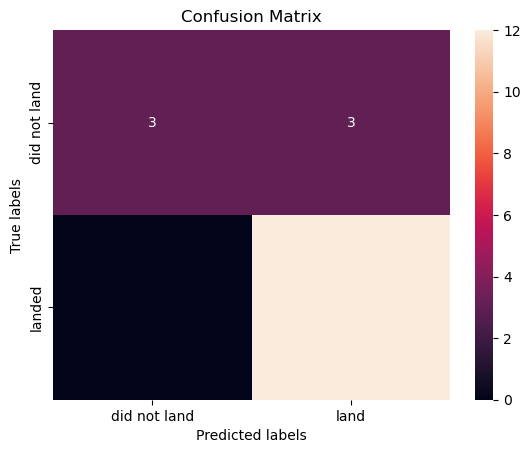

In [16]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  5


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [17]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [18]:
svm_cv = GridSearchCV(estimator=svm, cv=10, param_grid=parameters)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [19]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142858


## TASK  6


Calculating the accuracy on the test data 


In [20]:
print("accuracy :", svm_cv.score(X_test, Y_test))

accuracy : 0.8333333333333334


We can plot the confusion matrix


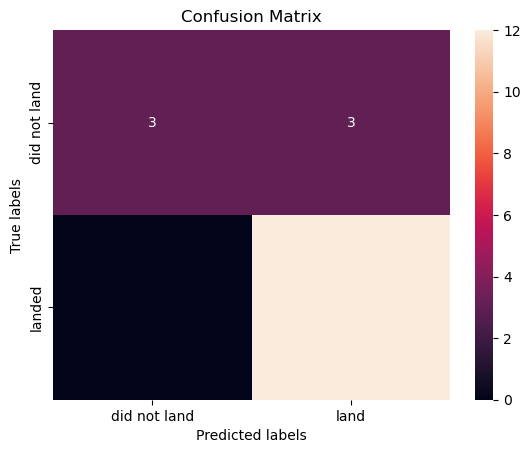

In [21]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  7


Creating a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [22]:
random.seed(8)
np.random.seed(8)

In [23]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [24]:
tree_cv = GridSearchCV(estimator=tree, cv=10, param_grid=parameters)
tree_cv.fit(X_train, Y_train)

/Users/hrishi/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/hrishi/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/hrishi/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/hrishi/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py", line 637, in _v

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [25]:
print("tuned hyperparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
accuracy : 0.8607142857142858


## TASK  8


In [26]:
print("accuracy :", tree_cv.score(X_test, Y_test))

accuracy : 0.7777777777777778


We can plot the confusion matrix


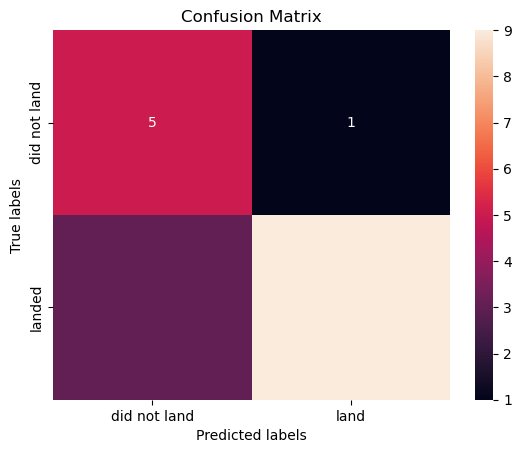

In [27]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  9


Creating a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [28]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [29]:
knn_cv = GridSearchCV(estimator=KNN, cv=10, param_grid=parameters)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [30]:
print("tuned hyperparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 6, 'p': 1}
accuracy : 0.8339285714285714


## TASK  10


In [31]:
print("accuracy :", knn_cv.score(X_test, Y_test))

accuracy : 0.8333333333333334


We can plot the confusion matrix


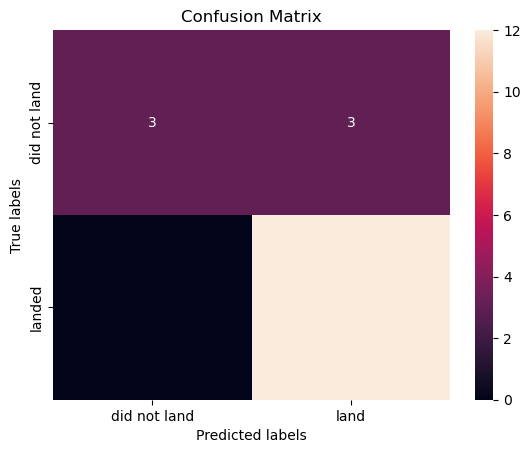

In [32]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  11


Find the method performs best:


In [33]:
print("Model\t\tAccuracy\tTestAccuracy")#,logreg_cv.best_score_)
print("LogReg\t\t{}\t\t{}".format((logreg_cv.best_score_).round(5), logreg_cv.score(X_test, Y_test).round(5)))
print("SVM\t\t{}\t\t{}".format((svm_cv.best_score_).round(5), svm_cv.score(X_test, Y_test).round(5)))
print("Tree\t\t{}\t\t{}".format((tree_cv.best_score_).round(5), tree_cv.score(X_test, Y_test).round(5)))
print("KNN\t\t{}\t\t{}".format((knn_cv.best_score_).round(5), knn_cv.score(X_test, Y_test).round(5)))

comparison = {}

comparison['LogReg'] = {'Accuracy': logreg_cv.best_score_.round(5), 'TestAccuracy': logreg_cv.score(X_test, Y_test).round(5)}
comparison['SVM'] = {'Accuracy': svm_cv.best_score_.round(5), 'TestAccuracy': svm_cv.score(X_test, Y_test).round(5)}
comparison['Tree'] = {'Accuracy': tree_cv.best_score_.round(5), 'TestAccuracy': tree_cv.score(X_test, Y_test).round(5)}
comparison['KNN'] = {'Accuracy': knn_cv.best_score_.round(5), 'TestAccuracy': knn_cv.score(X_test, Y_test).round(5)}

Model		Accuracy	TestAccuracy
LogReg		0.82143		0.83333
SVM		0.84821		0.83333
Tree		0.86071		0.77778
KNN		0.83393		0.83333


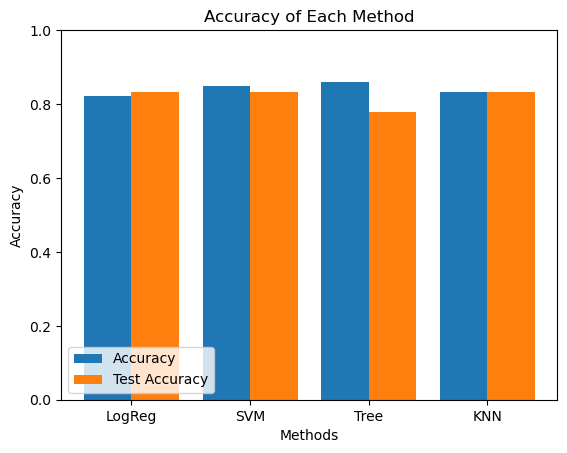

In [34]:
x = []
y1 = []
y2 = []
for meth in comparison.keys():
    x.append(meth)    
    y1.append(comparison[meth]['Accuracy'])
    y2.append(comparison[meth]['TestAccuracy'])
    

x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, y1, 0.4, label = 'Accuracy')
plt.bar(x_axis + 0.2, y2, 0.4, label = 'Test Accuracy')

plt.ylim([0,1])
plt.xticks(x_axis, x)

plt.xlabel("Methods")
plt.ylabel("Accuracy")
plt.title("Accuracy of Each Method")
plt.legend(loc='lower left')
plt.show()

## Cross validation

In [35]:
#using cross validation score with optimal parameters we achieved from hyperparameter tuning 
from sklearn.model_selection import cross_val_score

scores_svc = cross_val_score(SVC(C = 1.0, gamma =0.03162277660168379, kernel = 'sigmoid'),X,Y,cv = 10)
print('Average score of SVC: ',svc:=sum(scores_svc)/10)

scores_lr = cross_val_score(LogisticRegression(C = 1, penalty = 'l2', solver = 'lbfgs'),X,Y,cv = 10)
print('Average score of LR: ', lr:=sum(scores_lr)/10)

scores_dtc = cross_val_score(DecisionTreeClassifier(criterion= 'gini', max_depth= 6, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 5, splitter= 'best'),X,Y,cv = 10)
print('Average score of DTC: ', dtc:=sum(scores_dtc)/10)

scores_knc = cross_val_score(KNeighborsClassifier(algorithm= 'auto', n_neighbors=6, p= 1),X,Y,cv = 10)
print('Average score of KNC:',knc:=sum(scores_knc)/10)

Average score of SVC:  0.8222222222222223
Average score of LR:  0.788888888888889
Average score of DTC:  0.8
Average score of KNC: 0.8111111111111111


In [36]:
# Creating a simple dataframe for visualisation
acc_df = pd.DataFrame(
    {
        'Names': ['SVC','LR','DTC','KNC'],
        'Accuracy': [svc, lr, dtc, knc]
    }
)
acc_df

,Names,Accuracy
0,SVC,0.822222
1,LR,0.788889
2,DTC,0.800000
3,KNC,0.811111


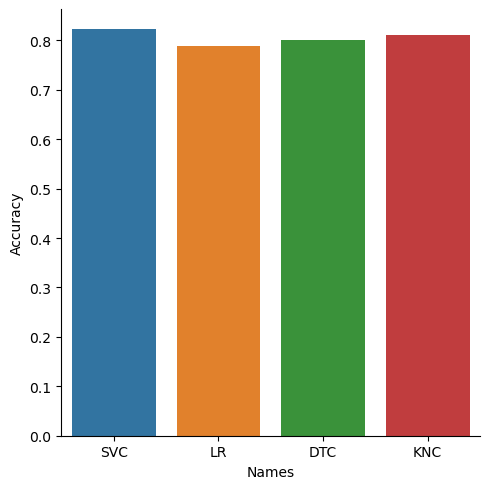

In [37]:
sns.catplot(x = 'Names', y = 'Accuracy', data = acc_df,kind = 'bar')

## Created by Hrishikesh Reddy Papasani 
### Github link: https://github.com/Hrishikesh-Papasani
### Gmail: hrpapasani@gmail.com